
## import

In [8]:
import os
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from datasets_prep.dataset import create_dataset
from diffusion import sample_from_model, sample_posterior, \
    q_sample_pairs, get_time_schedule, \
    Posterior_Coefficients, Diffusion_Coefficients
#from DWT_IDWT.DWT_IDWT_layer import DWT_2D, IDWT_2D
#from pytorch_wavelets import DWTForward, DWTInverse
from torch.multiprocessing import Process
from utils import init_processes, copy_source, broadcast_params
import yaml

from ldm.util import instantiate_from_config
from omegaconf import OmegaConf
import wandb

## utils

In [9]:
def load_model_from_config(config_path, ckpt):
    print(f"Loading model from {ckpt}")
    config = OmegaConf.load(config_path)
    pl_sd = torch.load(ckpt, map_location="cpu")
    #global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.first_stage_model
    model.cuda()
    model.eval()
    del m
    del u
    del pl_sd
    return model

def grad_penalty_call(args, D_real, x_t):
    grad_real = torch.autograd.grad(
        outputs=D_real.sum(), inputs=x_t, create_graph=True
    )[0]
    grad_penalty = (
        grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()

    grad_penalty = args.r1_gamma / 2 * grad_penalty
    grad_penalty.backward()

## config

In [10]:
from get_args import get_args
args = [
    "--dataset", "afhq_cat", "--image_size", "256",
    "--exp", "test", "--num_channels", "4",
    "--num_channels_dae", "128", "--ch_mult", "1", "2", "2", "2", 
    "--num_timesteps", "2", "--num_res_blocks", "2", 
    "--batch_size", "32", "--num_epoch", "200", 
    "--ngf", "64", "--embedding_type", "positional", 
    "--use_ema", "--ema_decay", "0.999",
    "--r1_gamma", "2.", "--nz", "100",
    "--z_emb_dim", "256", "--lr_d", "1.0e-4",
    "--lr_g", "2e-4", "--lazy_reg", "10",
    "--save_content", "--datadir", "data/afhq", 
    "--master_port", "6084", "--num_process_per_node", "0",
    "--current_resolution", "128", "--attn_resolution", "16",
    "--num_disc_layers", "4", "--rec_loss", 
    "--save_content_every", "1", "--AutoEncoder_config", "./autoencoder/config/kl-f2.yaml", 
    "--AutoEncoder_ckpt", "./autoencoder/weight/kl-f2.ckpt", "--scale_factor", "6.0", 
    "--no_lr_decay", "--sigmoid_learning"
]

args = get_args(args)


In [11]:
from get_args import get_args
args = [
    "--dataset", "cifar10", "--image_size", "32",
    "--exp", "test", "--num_channels", "4",
    "--num_channels_dae", "128", "--ch_mult", "1", "2", "2", "2", 
    "--num_timesteps", "2", "--num_res_blocks", "2", 
    "--batch_size", "32", "--num_epoch", "200", 
    "--ngf", "64", "--embedding_type", "positional", 
    "--use_ema", "--ema_decay", "0.999",
    "--r1_gamma", "2.", "--nz", "100",
    "--z_emb_dim", "256", "--lr_d", "1.0e-4",
    "--lr_g", "2e-4", "--lazy_reg", "10",
    "--save_content", "--datadir", "data/cifar-10", 
    "--master_port", "6084", "--num_process_per_node", "0",
    "--current_resolution", "16", "--attn_resolution", "16",
    "--num_disc_layers", "4", "--rec_loss", 
    "--save_content_every", "1", "--AutoEncoder_config", "./autoencoder/config/kl-f2.yaml", 
    "--AutoEncoder_ckpt", "./autoencoder/weight/kl-f2.ckpt", "--scale_factor", "6.0", 
    "--no_lr_decay", "--sigmoid_learning"
]

args = get_args(args)


## wandb setting


In [12]:
wandb.init(
            project="TEST",
            config={
                "dataset": args.dataset,
                "image_size": args.image_size,
                "channels": args.num_channels,
                "timesteps": args.num_timesteps,
                "nz": args.nz,
                "epochs": args.num_epoch,
                "ngf": args.ngf,
                "lr_g": args.lr_g,
                "lr_d": args.lr_d,
                "batch_size": args.batch_size,
                "r1_gamma": args.r1_gamma,
                "lazy_reg": args.lazy_reg,
                "use_ema": args.use_ema,
                "ema_decay": args.ema_decay,
                "no_lr_decay": args.no_lr_decay,
                "use_pytorch_wavelet": args.use_pytorch_wavelet,
                "rec_loss": args.rec_loss,
                "net_type": args.net_type,
                "num_disc_layers": args.num_disc_layers,
                "no_use_fbn": args.no_use_fbn,
                "no_use_freq": args.no_use_freq,
                "no_use_residual": args.no_use_residual,
                "scale_factor": args.scale_factor,
                "AutoEncoder_config": args.AutoEncoder_config,
                "AutoEncoder_ckpt": args.AutoEncoder_ckpt,
                "sigmoid_learning": args.sigmoid_learning,
            }
        )

D_loss_per_iter,█▁▁▁
G_loss_per_100iter,▄▇█▁
time_per_100iter,▁███
D_loss_per_iter,0.00564
G_loss_per_100iter,5.8771
time_per_100iter,7.98588


## train


In [13]:
rank = gpu = 0
from EMA import EMA
from score_sde.models.discriminator import Discriminator_large, Discriminator_small
from score_sde.models.ncsnpp_generator_adagn import NCSNpp, WaveletNCSNpp

torch.manual_seed(args.seed + rank)
torch.cuda.manual_seed(args.seed + rank)
torch.cuda.manual_seed_all(args.seed + rank)
device = torch.device('cuda:{}'.format(gpu))

batch_size = args.batch_size

nz = args.nz  # latent dimension

dataset = create_dataset(args)
#train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
#                                                                num_replicas=args.world_size,
#                                                                rank=rank)
data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=args.num_workers,
                                            pin_memory=True,
                                            drop_last=True)
args.ori_image_size = args.image_size
args.image_size = args.current_resolution
G_NET_ZOO = {"normal": NCSNpp, "wavelet": WaveletNCSNpp}
gen_net = G_NET_ZOO[args.net_type]
disc_net = [Discriminator_small, Discriminator_large]
print("GEN: {}, DISC: {}".format(gen_net, disc_net))
netG = gen_net(args).to(device)

if args.dataset in ['cifar10', 'stl10', 'afhq_cat']:
    netD = disc_net[0](nc=2 * args.num_channels, ngf=args.ngf,
                        t_emb_dim=args.t_emb_dim,
                        act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)
else:
    netD = disc_net[1](nc=2 * args.num_channels, ngf=args.ngf,
                        t_emb_dim=args.t_emb_dim,
                        act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)

#broadcast_params(netG.parameters())
#broadcast_params(netD.parameters())

optimizerD = optim.Adam(filter(lambda p: p.requires_grad, netD.parameters(
)), lr=args.lr_d, betas=(args.beta1, args.beta2))
optimizerG = optim.Adam(filter(lambda p: p.requires_grad, netG.parameters(
)), lr=args.lr_g, betas=(args.beta1, args.beta2))

if args.use_ema:
    optimizerG = EMA(optimizerG, ema_decay=args.ema_decay)

schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerG, args.num_epoch, eta_min=1e-5)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerD, args.num_epoch, eta_min=1e-5)

# ddp
#netG = nn.parallel.DistributedDataParallel(
#    netG, device_ids=[gpu])
#netD = nn.parallel.DistributedDataParallel(netD, device_ids=[gpu])

"""############### DELETE TO AVOID ERROR ###############"""
# Wavelet Pooling
#if not args.use_pytorch_wavelet:
#    dwt = DWT_2D("haar")
#    iwt = IDWT_2D("haar")
#else:
#    dwt = DWTForward(J=1, mode='zero', wave='haar').cuda()
#    iwt = DWTInverse(mode='zero', wave='haar').cuda()
    

#load encoder and decoder
config_path = args.AutoEncoder_config 
ckpt_path = args.AutoEncoder_ckpt 

if args.dataset in ['cifar10', 'stl10', 'coco', 'afhq_cat']:
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    
    AutoEncoder = instantiate_from_config(config['model'])
    

    checkpoint = torch.load(ckpt_path, map_location=device)
    AutoEncoder.load_state_dict(checkpoint['state_dict'])
    AutoEncoder.eval()
    AutoEncoder.to(device)

else:
    AutoEncoder = load_model_from_config(config_path, ckpt_path)
"""############### END DELETING ###############"""

num_levels = int(np.log2(args.ori_image_size // args.current_resolution))

exp = args.exp
parent_dir = "./saved_info/{}".format(args.dataset)

exp_path = os.path.join(parent_dir, exp)
if rank == 0:
    if not os.path.exists(exp_path):
        os.makedirs(exp_path)
        copy_source(__file__, exp_path)
        shutil.copytree('score_sde/models', os.path.join(exp_path, 'score_sde/models'))

coeff = Diffusion_Coefficients(args, device)
pos_coeff = Posterior_Coefficients(args, device)
T = get_time_schedule(args, device)

if args.resume or os.path.exists(os.path.join(exp_path, 'content.pth')):
    checkpoint_file = os.path.join(exp_path, 'content.pth')
    checkpoint = torch.load(checkpoint_file, map_location=device)
    init_epoch = checkpoint['epoch']
    epoch = init_epoch
    # load G
    netG.load_state_dict(checkpoint['netG_dict'])
    #optimizerG.load_state_dict(checkpoint['optimizerG'])
    schedulerG.load_state_dict(checkpoint['schedulerG'])
    # load D
    netD.load_state_dict(checkpoint['netD_dict'])
    #optimizerD.load_state_dict(checkpoint['optimizerD'])
    schedulerD.load_state_dict(checkpoint['schedulerD'])

    global_step = checkpoint['global_step']
    print("=> loaded checkpoint (epoch {})"
            .format(checkpoint['epoch']))
else:
    global_step, epoch, init_epoch = 0, 0, 0

'''Sigmoid learning parameter'''
gamma = 6
beta = np.linspace(-gamma, gamma, args.num_epoch+1)
alpha = 1 - 1 / (1+np.exp(-beta))

if args.dataset in ['cifar10'] and args.class_conditional:
    class_embedding = nn.Embedding(10, nz).to(device)

nrow = 2
if args.batch_size >= 5:
    nrow = 3
if args.batch_size >= 10:
    nrow = 10

Files already downloaded and verified
GEN: <class 'score_sde.models.ncsnpp_generator_adagn.NCSNpp'>, DISC: [<class 'score_sde.models.discriminator.Discriminator_small'>, <class 'score_sde.models.discriminator.Discriminator_large'>]
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
Working with z of shape (1, 4, 16, 16) = 1024 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
=> loaded checkpoint (epoch 2)


## train loop

In [7]:
for epoch in range(init_epoch, args.num_epoch + 1):
    #train_sampler.set_epoch(epoch)
    
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    start_epoch = torch.cuda.Event(enable_timing=True)
    end_epoch = torch.cuda.Event(enable_timing=True)
    start_epoch.record()
    for iteration, (x, y) in enumerate(data_loader):
        for p in netD.parameters():
            p.requires_grad = True
        netD.zero_grad()

        for p in netG.parameters():
            p.requires_grad = False

        # sample from p(x_0)
        x0 = x.to(device, non_blocking=True)

        """################# Change here: Encoder #################"""
        with torch.no_grad():
            posterior = AutoEncoder.encode(x0)
            real_data = posterior.sample().detach()
        #print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
        real_data = real_data / args.scale_factor #300.0  # [-1, 1]
        
        
        #assert -1 <= real_data.min() < 0
        #assert 0 < real_data.max() <= 1
        """################# End change: Encoder #################"""
        # sample t
        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)
        
        if args.dataset in ['cifar10'] and args.class_conditional:
            y = y.to(device)
            y_emb = class_embedding(y)

        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)
        x_t.requires_grad = True

        """################# Save Sample #################"""
        if iteration % 10 == 0:
            print(f"Epoch: {epoch}, Iteration: {iteration}")
        if iteration % 50 == 0:
            x_t_1 = torch.randn_like(posterior.sample())
            if args.dataset in ['cifar10'] and args.class_conditional:
                y = torch.arange(0, 10).repeat(x_t_1.size(0)//10 + 1)[:x_t_1.size(0)].to(device)
                y_emb = class_embedding(y)
                fake_sample = sample_from_model(
                    pos_coeff, netG, args.num_timesteps, x_t_1, T, args, class_emb=y_emb)
            else:
                fake_sample = sample_from_model(
                    pos_coeff, netG, args.num_timesteps, x_t_1, T, args)
            fake_sample *= args.scale_factor #300
            with torch.no_grad():
                fake_sample = AutoEncoder.decode(fake_sample)

            #rec_data = (torch.clamp(rec_data, -1, 1) + 1) / 2
            fake_sample = (torch.clamp(fake_sample, -1, 1) + 1) / 2  # 0-1
            torchvision.utils.save_image(fake_sample, os.path.join(
                exp_path, 'sample_discrete_epoch_{}.png'.format(epoch)), nrow=nrow)


        # train with real
        D_real = netD(x_t, t, x_tp1.detach()).view(-1)
        errD_real = F.softplus(-D_real).mean()

        errD_real.backward(retain_graph=True)

        if args.lazy_reg is None:
            grad_penalty_call(args, D_real, x_t)
        else:
            if global_step % args.lazy_reg == 0:
                grad_penalty_call(args, D_real, x_t)

        # train with fake
        latent_z = torch.randn(batch_size, nz, device=device)
        if args.dataset in ['cifar10'] and args.class_conditional:
            x_0_predict = netG(x_tp1.detach(), t, torch.cat([latent_z, y_emb], dim=1).detach())
        else:
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errD_fake = F.softplus(output).mean()

        errD_fake.backward()

        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # update G
        for p in netD.parameters():
            p.requires_grad = False

        for p in netG.parameters():
            p.requires_grad = True
        netG.zero_grad()

        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)
        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)

        latent_z = torch.randn(batch_size, nz, device=device)
        if args.dataset in ['cifar10'] and args.class_conditional:
            x_0_predict = netG(x_tp1.detach(), t, torch.cat([latent_z, y_emb], dim=1).detach())
        else:
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errG = F.softplus(-output).mean()

        # reconstructior loss
        if args.sigmoid_learning and args.rec_loss:
            ######alpha
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + alpha[epoch]*rec_loss

        elif args.rec_loss and not args.sigmoid_learning:
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + rec_loss
        

        errG.backward()
        optimizerG.step()

        global_step += 1
        if iteration % 100 == 0:
            if rank == 0:
                end.record()
                torch.cuda.synchronize()
                elapsed_time = start.elapsed_time(end)
                if args.sigmoid_learning:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, alpha: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), alpha[epoch]))
                elif args.rec_loss:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, rec_loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), rec_loss.item()))
                else:   
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item()))
                wandb.log({"G_loss_per_100iter": errG.item(), "D_loss_per_iter": errD.item(), "time_per_100iter": elapsed_time / 1000})
                start = torch.cuda.Event(enable_timing=True)
                end = torch.cuda.Event(enable_timing=True)
                start.record()

    if not args.no_lr_decay:

        schedulerG.step()
        schedulerD.step()

    if rank == 0:
        end_epoch.record()
        torch.cuda.synchronize()
        time_per_epoch = start_epoch.elapsed_time(end_epoch)
        wandb.log({"G_loss": errG.item(), "D_loss": errD.item(), "alpha": alpha[epoch], "time_per_epoch": time_per_epoch / 1000})
        ########################################
        x_t_1 = torch.randn_like(posterior.sample())
        if args.dataset in ['cifar10'] and args.class_conditional:
            y = torch.arange(0, 10).repeat(x_t_1.size(0)//10 + 1)[:x_t_1.size(0)].to(device)
            y_emb = class_embedding(y)
            fake_sample = sample_from_model(
                pos_coeff, netG, args.num_timesteps, x_t_1, T, args, class_emb=y_emb)
        else:
            fake_sample = sample_from_model(
                pos_coeff, netG, args.num_timesteps, x_t_1, T, args)

        """############## CHANGE HERE: DECODER ##############"""
        fake_sample *= args.scale_factor #300
        real_data *= args.scale_factor #300
        with torch.no_grad():
            fake_sample = AutoEncoder.decode(fake_sample)
            real_data = AutoEncoder.decode(real_data)
        
        fake_sample = (torch.clamp(fake_sample, -1, 1) + 1) / 2  # 0-1
        real_data = (torch.clamp(real_data, -1, 1) + 1) / 2  # 0-1 
        
        """############## END HERE: DECODER ##############"""

        torchvision.utils.save_image(fake_sample, os.path.join(
            exp_path, 'sample_discrete_epoch_{}.png'.format(epoch)), nrow=nrow)
        torchvision.utils.save_image(
            real_data, os.path.join(exp_path, 'real_data.png'),nrow=nrow)

        if args.save_content:
            if epoch % args.save_content_every == 0:
                print('Saving content.')
                content = {'epoch': epoch + 1, 'global_step': global_step, 'args': args,
                           'netG_dict': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                           'schedulerG': schedulerG.state_dict(), 'netD_dict': netD.state_dict(),
                           'optimizerD': optimizerD.state_dict(), 'schedulerD': schedulerD.state_dict()}
                torch.save(content, os.path.join(exp_path, 'content.pth'))

        if epoch % args.save_ckpt_every == 0:
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)

            torch.save(netG.state_dict(), os.path.join(
                exp_path, 'netG_{}.pth'.format(epoch)))
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)


/scratch/users/std/2021/21k0005/improved-ddgan/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 2, Iteration: 0
OUTTTT
epoch 2 iteration0, G Loss: 7.687418460845947, D Loss: 0.08819055557250977, alpha: 0.9972130037809577
Epoch: 2, Iteration: 10
Epoch: 2, Iteration: 20
Epoch: 2, Iteration: 30
Epoch: 2, Iteration: 40
Epoch: 2, Iteration: 50
OUTTTT
Epoch: 2, Iteration: 60
Epoch: 2, Iteration: 70
Epoch: 2, Iteration: 80
Epoch: 2, Iteration: 90
Epoch: 2, Iteration: 100
OUTTTT
epoch 2 iteration100, G Loss: 9.737632751464844, D Loss: 0.0017735939472913742, alpha: 0.9972130037809577
Epoch: 2, Iteration: 110
Epoch: 2, Iteration: 120
Epoch: 2, Iteration: 130
Epoch: 2, Iteration: 140
Epoch: 2, Iteration: 150
OUTTTT
Epoch: 2, Iteration: 160
Epoch: 2, Iteration: 170
Epoch: 2, Iteration: 180
Epoch: 2, Iteration: 190
Epoch: 2, Iteration: 200
OUTTTT
epoch 2 iteration200, G Loss: 10.644046783447266, D Loss: 0.0027751740999519825, alpha: 0.9972130037809577
Epoch: 2, Iteration: 210
Epoch: 2, Iteration: 220
Epoch: 2, Iteration: 230
Epoch: 2, Iteration: 240
Epoch: 2, Iteration: 250
OUTTTT
Epoc

KeyboardInterrupt: 

## show image

In [14]:
from PIL import Image

In [15]:
tmp = iter(data_loader)
x, y = next(tmp)

In [16]:
x.shape, y

(torch.Size([32, 3, 32, 32]),
 tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
         2, 6, 3, 5, 4, 0, 0, 9]))

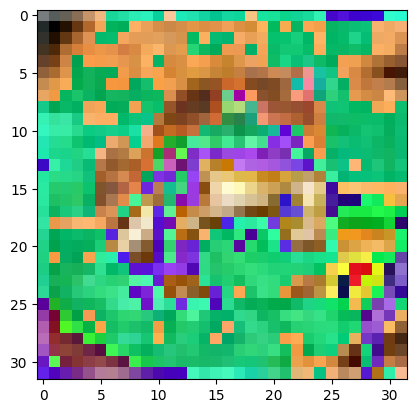

In [17]:
import matplotlib.pyplot as plt
from torchvision import transforms
img = transforms.ToPILImage(mode="RGB")(x[0])
plt.imshow(img)
plt.show()

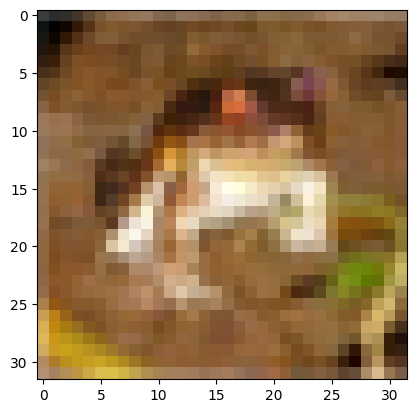

In [19]:
real_data = (torch.clamp(x[0], -1, 1) + 1) / 2
img = transforms.ToPILImage(mode="RGB")(real_data)
plt.imshow(img)
plt.show()

In [ ]:
real_data = (torch.clamp(x[3], -1, 1) + 1) / 2  # 0-1 

torchvision.utils.save_image(
    real_data, os.path.join("./", 'real_data.png'))
imgPIL = Image.open("./real_data.png")  # 画像読み込み

print(y[3])
imgPIL.show()  # 画像表示

In [ ]:
from ldm.util import instantiate_from_config
config_path = "./autoencoder/config/kl-f2.yaml"
ckpt_path = "./autoencoder/weight/kl-f2.ckpt"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

AutoEncoder2 = instantiate_from_config(config['model'])


checkpoint = torch.load(ckpt_path, map_location=device)
AutoEncoder2.load_state_dict(checkpoint['state_dict'])
AutoEncoder2.eval()
AutoEncoder2.to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
x0 = x.to(device)
print(x0.shape)
with torch.no_grad():
    posterior = AutoEncoder.encode(x0)
    real_data = posterior.detach()
print(real_data.shape)

In [ ]:
x0 = x.to(device)
with torch.no_grad():
    posterior = AutoEncoder2.encode(x0)
    real_data = posterior.sample().detach()
print(real_data.shape)